## Importing Libraries

In [1]:
import os
import wget
import zipfile

import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Loading Pre-trained Model and Weights

In [4]:
path = os.getcwd()+"\data\inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights = wget.download(url, out = path)

100% [........................................................................] 87910968 / 87910968

In [2]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [3]:
pre_trained_model.load_weights(path)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [4]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


## Building Model
**Dropout feature has been used in this model**

The idea behind Dropouts is that they remove a random number of neurons in your neural network. This works very well for two reasons: The first is that neighboring neurons often end up with similar weights, which can lead to overfitting, so dropping some out at random can remove this. The second is that often a neuron can over-weigh the input from a neuron in the previous layer, and can over specialize as a result. Thus, dropping out can break the neural network out of this potential bad habit!

In [5]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Using the above Model for Cats v. Dogs 

In [8]:
# Loading Data
ds_path = os.getcwd()+"\data\cat-dog.zip"
url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
train = wget.download(url, out = ds_path)

# Extracting Data
local_zip = 'data/cat-dog.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('data/')
zip_ref.close()

# Define our example directories and files
base_dir = 'data\cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Fitting

In [9]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
Epoch 1/20
100/100 - 221s - loss: 0.5109 - acc: 0.7570 - val_loss: 0.1502 - val_acc: 0.9480
Epoch 2/20
Epoch 1/20
100/100 - 206s - loss: 0.3832 - acc: 0.8300 - val_loss: 0.3108 - val_acc: 0.9280
Epoch 3/20
Epoch 1/20
100/100 - 207s - loss: 0.3292 - acc: 0.8615 - val_loss: 0.2620 - val_acc: 0.9520
Epoch 4/20
Epoch 1/20
100/100 - 203s - loss: 0.3319 - acc: 0.8570 - val_loss: 0.3540 - val_acc: 0.9340
Epoch 5/20
Epoch 1/20
100/100 - 204s - loss: 0.3162 - acc: 0.8660 - val_loss: 0.2839 - val_acc: 0.9490
Epoch 6/20
Epoch 1/20
100/100 - 203s - loss: 0.2986 - acc: 0.8755 - val_loss: 0.3199 - val_acc: 0.9440
Epoch 7/20
Epoch 1/20
100/100 - 208s - loss: 0.3128 - acc: 0.8730 - val_loss: 0.3230 - val_acc: 0.9520
Epoch 8/20
Epoch 1/20
100/100 - 216s - loss: 0.2873 - acc: 0.8850 - val_loss: 0.2853 - val_acc: 0.9510
Epoch 9/20
Epoch 1/20
100/100 - 214s - loss: 0.2885 - acc: 0.8760 - val_loss: 0.4881 - val_acc: 0.9390
Epoch 10/20
Epoch 1/20
100/100 - 214s - loss: 0.2734 - acc: 0.8925 - val_

## Visualising Traing and Validation Accuracy and Loss

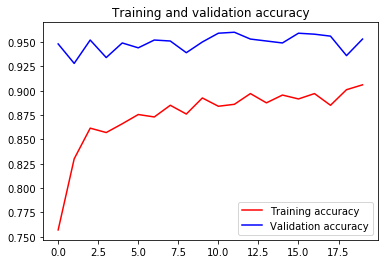

<Figure size 432x288 with 0 Axes>

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()